# Trabalho de Epidemiologia

## Alunos:  
Gustavo Bianchi da Silva  
Guilherme Carvalho Cunha  
Luiz Felipe de Abreu Marciano  

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

### Questão 1

> Gere uma rede aleatória (ER) com 10000 vértices e grau médio $\langle k \rangle = 20$. Comece com 5 vértices infectados escolhidos aleatoriamente. Execute múltiplas simulações da propagação da infecção pelo modelo SIS com os parâmetros abaixo e compare com os resultados esperados. (sugestão: faça em torno de 100 simulações e descreva o comportamento da epidemia “na média”)
>
> a. $\beta = 0.02$ e $\mu = 0.1$
> b. $\beta = 0.02$ e $\mu = 0.4$
> c. $\beta = 0.02$ e $\mu = 0.5$
>
> Mostre que se $R_0 = \frac{\beta \langle k \rangle}{\mu} > 1$ então a doença se fixa na rede no modelo SIS de campo médio.

---

### Análise Teórica e Resultados

A fim de analisar a fixação da doença podemos utilizar a fórmula da aproximação de campo médio: $\frac{di}{dt} = \beta \langle k \rangle i (1 - i) - \mu i$. Nela, temos que o estado estacionário é observado em $\frac{di}{dt} = 0$, e, com isso, podemos isolar o termo $i$ para obter a relação do mesmo com $R_0$:

$$i^* = 1 - \frac{1}{R_0}, \quad \text{com } R_0 = \frac{\beta \langle k \rangle}{\mu}$$
Em uma doença que se fixa, portanto, observamos $1 - \frac{1}{R_0} > 0$ (**$R_0 > 1$**). Se $R_0$ for menor que $1$, o equilíbrio tende a zero ou assume valores negativos, sendo interpretados como extinção.

Abaixo temos alguns testes feitos com os três cenários propostos para comparar a teoria com simulações. Consideramos $\langle k \rangle = 20$:

**Cenário a. : $\beta = 0.02, \mu = 0.1$**
$$R_0 = \frac{0.02 \times 20}{0.1} = 4.0$$
$$i^* = 1 - \frac{1}{4.0} = 0.75$$
**Resultado:** Temos $R_0 > 1$, ou seja, a doença se fixa. É esperado que a simulação se estabilize com **75%** da população afetada.

**Cenário b. : $\beta = 0.02, \mu = 0.4$**
$$R_0 = \frac{0.02 \times 20}{0.4} = 1.0$$
$$i^* = 1 - \frac{1}{1.0} = 0$$
**Resultado:** Aqui temos o ponto crítico.  Pode haver flutuações, mas o equilíbrio estável em **0%** culmina em uma extinção rápida em simulaçõe finitas e de poucos inicialmente contaminados.

**Cenário c. : $\beta = 0.02, \mu = 0.5$**
$$R_0 = \frac{0.02 \times 20}{0.5} = 0.8$$
$$i^* = 1 - \frac{1}{0.8} = -0.25 \rightarrow 0$$
**Resultado:** Temos $R_0 < 1$, ou seja, tendência a rápida extinção (taxa de recuperação mais intensa que de infecção).

Gerando Rede ER (N=10000, p=0.002)...
Grau médio realizado: 19.9418
Simulando cenário: a) R0=4.0 (Endêmico)
  -> Valor final médio: 0.74919 (IC: 0.74826 - 0.75012)
Simulando cenário: b) R0=1.0 (Crítico)
  -> Valor final médio: 0.00000 (IC: 0.00000 - 0.00000)
Simulando cenário: c) R0=0.8 (Extinção)
  -> Valor final médio: 0.00000 (IC: 0.00000 - 0.00000)


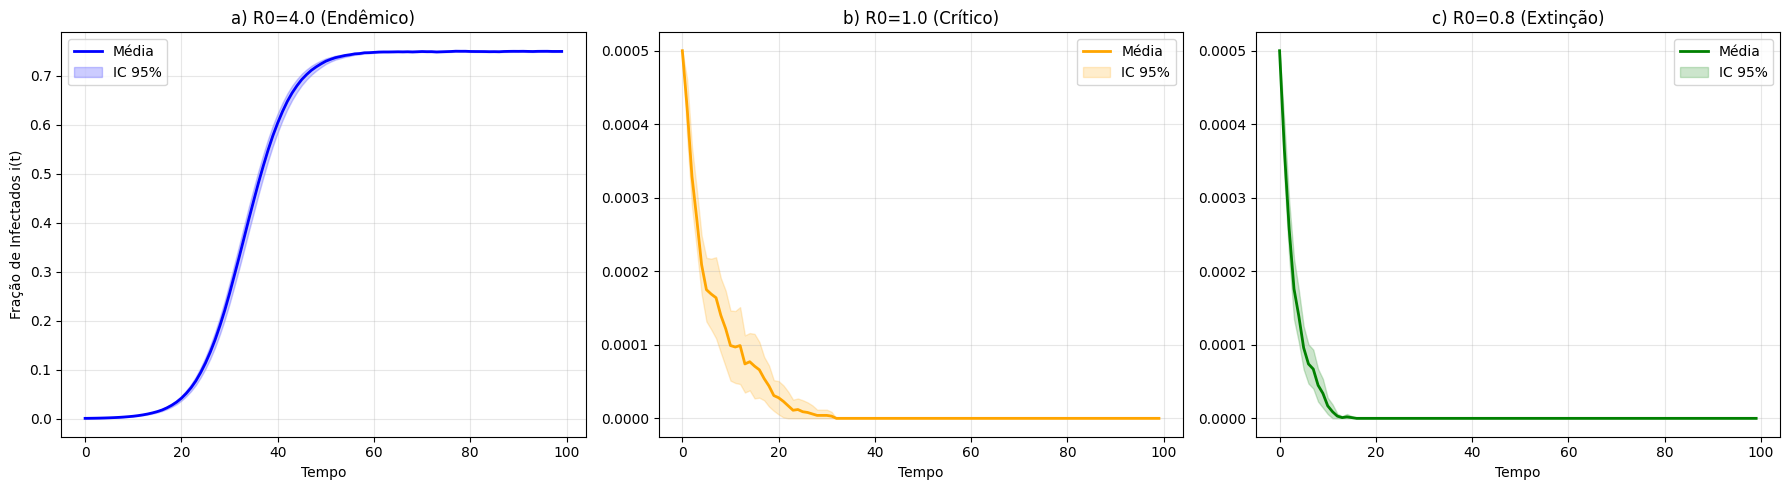

In [3]:
def run_sis_simulation(G, beta, mu, initial_infected=5, steps=100):
    status = np.zeros(len(G), dtype=int)
    initial_nodes = np.random.choice(len(G), initial_infected, replace=False)
    status[initial_nodes] = 1
    
    history = np.zeros(steps)
    
    for t in range(steps):
        history[t] = np.sum(status) / len(G)
        
        infected_indices = np.where(status == 1)[0]
        if len(infected_indices) == 0:
            continue
            
        # Recuperação
        recovering = np.random.random(len(infected_indices)) < mu
        status[infected_indices[recovering]] = 0
        
        # Infecção
        new_infected_indices = []
        infected_indices = np.where(status == 1)[0] 
        
        for node in infected_indices:
            neighbors = list(G.neighbors(node))
            for neighbor in neighbors:
                if status[neighbor] == 0:
                    if np.random.random() < beta:
                        new_infected_indices.append(neighbor)
        
        if new_infected_indices:
            status[np.unique(new_infected_indices)] = 1
            
    return history

# Config
N = 10000
k_avg = 20
p = k_avg / N
simulations = 100
steps = 100

print(f"Gerando Rede ER (N={N}, p={p})...")
G = nx.erdos_renyi_graph(n=N, p=p)

degrees = np.array([d for n, d in G.degree()])
k_avg_real = np.mean(degrees)
print(f"Grau médio realizado: {k_avg_real:.4f}")

scenarios = [
    {'label': 'a) R0=4.0 (Endêmico)', 'beta': 0.02, 'mu': 0.1, 'color': 'blue'},
    {'label': 'b) R0=1.0 (Crítico)', 'beta': 0.02, 'mu': 0.4, 'color': 'orange'},
    {'label': 'c) R0=0.8 (Extinção)', 'beta': 0.02, 'mu': 0.5, 'color': 'green'}
]

# Criando os subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, scen in enumerate(scenarios):
    print(f"Simulando cenário: {scen['label']}")
    
    all_runs = []
    
    for _ in range(simulations):
        hist = run_sis_simulation(G, scen['beta'], scen['mu'], steps=steps)
        all_runs.append(hist)
    
    # Converte para array numpy 2D (simulations x steps)
    all_runs = np.array(all_runs)
    
    # Cálculos Estatísticos
    mean_curve = np.mean(all_runs, axis=0)
    std_curve = np.std(all_runs, axis=0)
    
    # Intervalo de Confiança
    se_curve = std_curve / np.sqrt(simulations)
    ci_upper = mean_curve + 1.96 * se_curve
    ci_lower = mean_curve - 1.96 * se_curve
    
    # Clip para não mostrar valores negativos no gráfico
    ci_lower = np.maximum(ci_lower, 0)
    
    # Plotagem
    time_axis = range(steps)
    
    # Linha da média
    axs[i].plot(time_axis, mean_curve, label=f"Média", color=scen['color'], linewidth=2)
    
    # Sombra do IC
    axs[i].fill_between(time_axis, ci_lower, ci_upper, color=scen['color'], alpha=0.2, label='IC 95%')
    
    axs[i].set_title(scen['label'])
    axs[i].set_xlabel('Tempo')
    if i == 0:
        axs[i].set_ylabel('Fração de Infectados i(t)')
    
    axs[i].grid(True, alpha=0.3)
    axs[i].legend()
    
    print(f"  -> Valor final médio: {mean_curve[-1]:.5f} (IC: {ci_lower[-1]:.5f} - {ci_upper[-1]:.5f})")

plt.tight_layout()
plt.show()

### Questão 2

> Gere uma rede “livre de escala” com 10000 vértices, grau médio $\langle k \rangle \approx 20$ e expoente $\gamma = 2.5$. Comece com 5 vértices infectados escolhidos aleatoriamente. Execute múltiplas simulações da propagação da infecção pelo modelo SIS com os parâmetros abaixo e compare com os resultados esperados.
>
> a. $\beta = 0.01$ e $\mu = 0.1$
> b. $\beta = 0.01$ e $\mu = 0.2$
> c. $\beta = 0.01$ e $\mu = 0.3$
>
> Descreva o comportamento da epidemia e compare com o item (1).

---

### Análise e Comparação com Redes Aleatórias

**Diferenças na Estrutura:**

Gerando a rede Livre de Escala com o Configuration Model, remoções de arestas múltiplas e laços (comuns em nós de alto grau) fazem com que o grau médio real seja um pouco menor do que ao alvo (20). Porém, a característica determinante ainda se mantém presente: a ocorrência de **Hubs** acompanhados de muitos nós com baixo grau ($k=1, 2$).

Essa diferença na distribuição de conexões altera bastante a forma como a epidemia se espalha em comparação à rede aleatória da questão 1 (ER):

**Cenário a. (Endêmico): $\beta=0.01, \mu=0.1$**
* **Observado:** O estado estacionário com prevalência ocorre quando o sistema atinge aprox. **30%** ($i^* \approx 0.30$).
* **Comparação:** Na rede ER, a prevalência era muito maior (aprox. 75%).
* **Explicação:** Embora os hubs sejam facilmente infectados, a grande maioria da rede scale-free é composta por nós de baixíssimo grau (periferia). A doença tem dificuldade em se sustentar nessa periferia, reduzindo a média global de infectados em comparação à rede homogênea onde todos tinham ~20 vizinhos.

**Cenário b. (Crítico): $\beta=0.01, \mu=0.2$**
* **Observado:** A doença não é extinta, se mantendo em um nível baixo (< 10%).
* **Comparação:** Na rede ER este mesmo cenário, $R_0 \approx 1$, levava à extinção ou instabilidade.
* **Explicação:** Este resultado demonstra a **ausência de limiar epidêmico** prático em redes scale-free. Os hubs acabam atuando na manutenção do vírus, conservando a atividade da doença mesmo quando a taxa de transmissão não seria suficiente para mantê-la em uma rede aleatória.

**Cenário c. (Subcrítico) $\beta=0.01, \mu=0.3$**
* **Observado:** A doença persiste próxima de zero, resistindo a extinção completa.
* **Comparação:** Na rede ER, a extinção era rápida e determinística.
* **Explicação:** A alta variância da distribuição de graus ($\langle k^2 \rangle$) permite que a infecção "se esconda" nos nós mais conectados, criando um estado equilíbrio frágil, mas de de longa duração.


**Conclusão:**
Enquanto a rede Aleatória (ER) se comporta como um bloco homogêneo (todos pegam ou ninguém pega), a rede scale-free é hierárquica. Ela é mais frágil no sentido de que doenças difíceis de pegar (cenários b e c) conseguem sobreviver graças aos hubs, mas a prevalência total tende a ser menor em surtos fortes (cenário a) devido à dificuldade de penetração na periferia pouco conectada.

Gerando sequência de graus...
Gerando Grafo e removendo self loops...
Grau médio realizado: 19.46
Momento <k^2>: 3485.40
Razão de Heterogeneidade <k^2>/<k>: 179.13
Simulando: a) b=0.01, mu=0.1
Simulando: b) b=0.01, mu=0.2
Simulando: c) b=0.01, mu=0.3


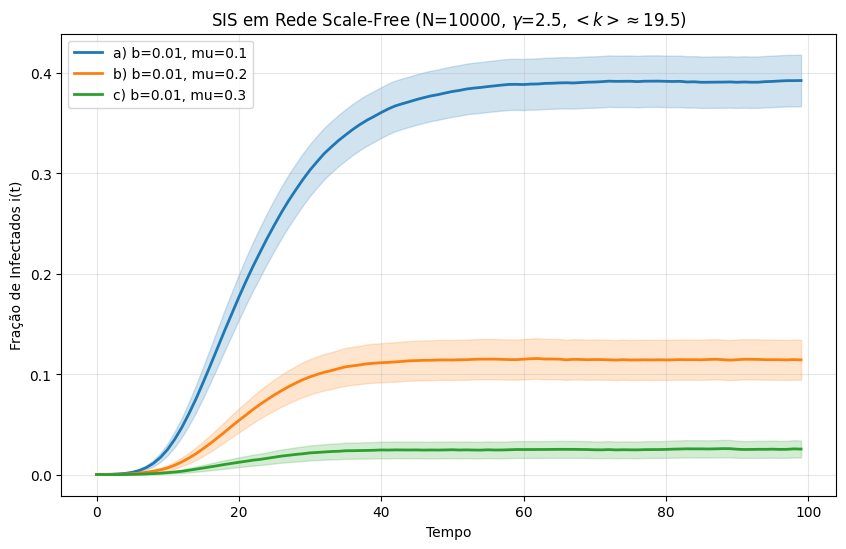

In [20]:
def generate_scale_free_sequence(N, gamma, target_k):
    k_min = int(target_k * (gamma - 2) / (gamma - 1))
    if k_min < 1: k_min = 1
    
    # Usando transformação inversa para controle contínuo aproximado
    r = np.random.random(N)
    degrees = k_min * (1 - r)**(-1/(gamma - 1))
    degrees = degrees.astype(int)
    
    # Ajuste fino para garantir soma par
    if np.sum(degrees) % 2 != 0:
        degrees[0] += 1
    return degrees

def run_sis_simulation(G, beta, mu, initial_infected=5, steps=100):
    status = np.zeros(len(G), dtype=int)
    # Escolha aleatória de infectados iniciais
    initial_nodes = np.random.choice(len(G), initial_infected, replace=False)
    status[initial_nodes] = 1
    
    history = np.zeros(steps)
    nodes = np.array(G.nodes())
    adj_list = [list(G.neighbors(n)) for n in G.nodes()] # Cache para performance
    
    for t in range(steps):
        history[t] = np.sum(status) / len(G)
        infected_indices = np.where(status == 1)[0]
        
        if len(infected_indices) == 0: continue
            
        # Recuperação
        recovering = np.random.random(len(infected_indices)) < mu
        status[infected_indices[recovering]] = 0
        
        # Infecção
        infected_indices = np.where(status == 1)[0]
        for node_idx in infected_indices:
            neighbors = adj_list[node_idx]
            for neighbor in neighbors:
                if status[neighbor] == 0:
                    if np.random.random() < beta:
                        status[neighbor] = 1
    return history

# Parâmetros
N = 10000
gamma = 2.5
target_k = 23 # Um pouco maior pra que o realizado seja próximo de 20
steps = 100
simulations = 100

# Gerando Rede Scale-Free
print("Gerando sequência de graus...")
seq = generate_scale_free_sequence(N, gamma, target_k)
print(f"Gerando Grafo e removendo self loops...")
G = nx.configuration_model(seq)
G = nx.Graph(G) # Converte para grafo simples (remove arestas múltiplas)
G.remove_edges_from(nx.selfloop_edges(G)) # Remove self-loops

# Recalcular estatísticas reais da rede gerada
degrees = np.array([d for n, d in G.degree()])
k_avg_real = np.mean(degrees)
k2_avg_real = np.mean(degrees**2)
print(f"Grau médio realizado: {k_avg_real:.2f}")
print(f"Momento <k^2>: {k2_avg_real:.2f}")
print(f"Razão de Heterogeneidade <k^2>/<k>: {k2_avg_real/k_avg_real:.2f}")

scenarios = [
    {'label': 'a) b=0.01, mu=0.1', 'beta': 0.01, 'mu': 0.1},
    {'label': 'b) b=0.01, mu=0.2', 'beta': 0.01, 'mu': 0.2},
    {'label': 'c) b=0.01, mu=0.3', 'beta': 0.01, 'mu': 0.3}
]

plt.figure(figsize=(10, 6))

for scen in scenarios:
    print(f"Simulando: {scen['label']}")
    
    all_runs = []
    
    for _ in range(simulations):
        run_data = run_sis_simulation(G, scen['beta'], scen['mu'], steps=steps)
        all_runs.append(run_data)
    
    # Converte para matriz numpy (simulations x steps)
    all_runs = np.array(all_runs)
    
    # Cálculo das Estatísticas
    mean_curve = np.mean(all_runs, axis=0)
    std_curve = np.std(all_runs, axis=0)
    
    # Pra plotar o intervalo de confiança
    se_curve = std_curve / np.sqrt(simulations)
    ci_upper = mean_curve + 1.96 * se_curve
    ci_lower = mean_curve - 1.96 * se_curve
    ci_lower = np.maximum(ci_lower, 0) 
    
    # Plotagem
    time_axis = range(steps)
    # Plota a linha média e captura a cor usada
    line = plt.plot(time_axis, mean_curve, label=scen['label'], linewidth=2)
    color = line[0].get_color()
    
    # Plota a sombra do intervalo de confiança com a mesma cor
    plt.fill_between(time_axis, ci_lower, ci_upper, color=color, alpha=0.2)

plt.title(f'SIS em Rede Scale-Free (N={N}, $\gamma$={gamma}, $<k>\\approx${k_avg_real:.1f})')
plt.xlabel('Tempo')
plt.ylabel('Fração de Infectados i(t)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Questão 3

> Considere o exercício anterior, letra a. Descubra o número de vértices imunizados previamente que são necessários para impedir a fixação do estado endêmico nos seguintes cenários:
> a. Os vértices imunizados são escolhidos aleatoriamente.
> b. Os vértices imunizados são os de maior grau (hubs).
> c. Os vértices imunizados são os vizinhos de vértices escolhidos aleatoriamente.
>
> Descreva (brevemente, com um ou dois parágrafos) como a fração de vacinados em cada caso se relaciona com o tema de robustez da rede visto em sala de aula.

---

### Análise de Imunização e Robustez

Com base nas simulações feitas, podemos avaliar os limiares aproximados de imunização para erradicar a doença nos diferentes cenários propostos:

* **Aleatória:** Ineficaz. A epidemia se manteve mesmo com taxas de vacinação maiores que >80%.
* **Hubs:** Muito eficaz. Vacinar de 10 a 15% do grupo já é o suficiente para erradicar a doença.
* **c. Vizinhos:** Eficaz. Erradicação da doença com uma taxa de vacinação de aproximadamente 20-25%.

**Relação com a Robustez da Rede 'Robusta porém Frágil':**
Observando os resultado é notável a presença de uma a propriedade fundamental das redes scale-free conhecida como "Robusta, porém Frágil". A ineficiência da imunização aleatória do caso **a** remete a **robustez a falhas**, já que como a probabilidade de remover um hub é estatisticamente nula, remover um nó aleatório não gera fragmentação na rede nem interrompe a propagação. Em adição à isso, a eficiência da imunização baseada em grau do caso **b** induz a **fragilidade a ataques**, onde a rede acaba sendo dependente dos hubs para manter sua conectividade. Removendo esses hubs, a epidemia colapsa por uma fragmentação funcional da rede. O caso **c** (imunização de vizinhos) explora essa fragilidade através do chamado 'Paradoxo da Amizade', localizando hubs heuristicamente sem precisar mapear a rede globalmente.

Executando varredura de imunização...
Processando estratégia: random
Processando estratégia: neighbor
Processando estratégia: hubs


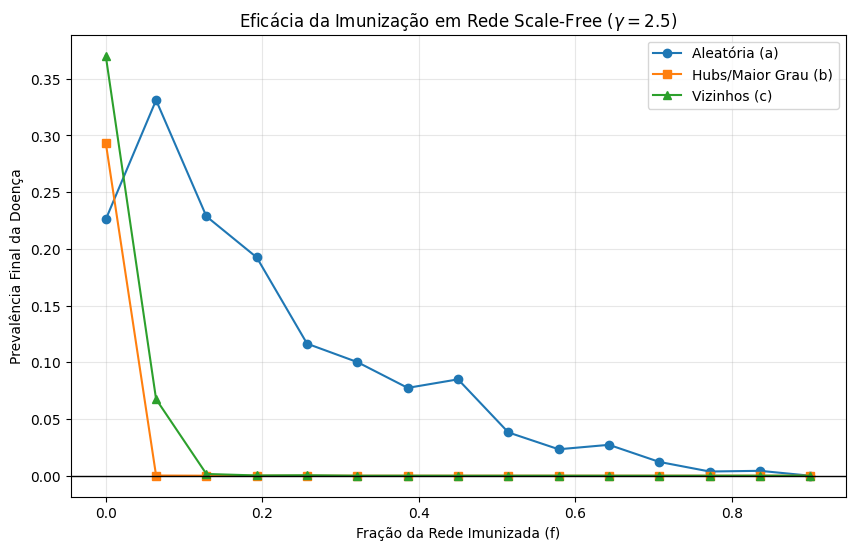

In [ ]:
# Gerando a rede scale-dree (mesma do exercício anterior)
def generate_scale_free_graph(N, gamma, target_k):
    k_min = int(target_k * (gamma - 2) / (gamma - 1))
    if k_min < 1: k_min = 1
    
    while True:
        r = np.random.random(N)
        degrees = k_min * (1 - r)**(-1/(gamma - 1))
        degrees = degrees.astype(int)
        if np.sum(degrees) % 2 == 0: break # Soma deve ser par
            
    G = nx.configuration_model(degrees)
    G = nx.Graph(G)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G

# Aplicando as estratégias de imunização
def get_immunized_nodes(G, fraction, strategy):
    num_immunized = int(len(G) * fraction)
    if num_immunized == 0: return []
    
    nodes = list(G.nodes())
    
    if strategy == 'random':
        return np.random.choice(nodes, num_immunized, replace=False)
    
    elif strategy == 'hubs':
        # Ordenando por grau decrescente e selecionando os top K
        sorted_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)
        return [n for n, d in sorted_nodes[:num_immunized]]
    
    elif strategy == 'neighbor':
        # Escolhe aleatório -> pega um vizinho dele (Friendship Paradox)
        immunized = set()
        while len(immunized) < num_immunized:
            target = np.random.choice(nodes)
            neighbors = list(G.neighbors(target))
            if neighbors:
                chosen = np.random.choice(neighbors)
                immunized.add(chosen)
            else:
                # Se é nó isolado, imuniza ele mesmo (fallback)
                immunized.add(target) 
        return list(immunized)

# Simulação SIS com imunização
def run_sis_with_immunity(G, beta, mu, immunized_nodes, initial_infected=5, steps=50):
    status = np.zeros(len(G), dtype=int) # 0: Suscetível, 1: Infectado, -1: Imune
    
    # Aplica vacina
    status[immunized_nodes] = -1
    
    # Infecta iniciais (garantindo que não infecte vacinados)
    susceptible = [n for n in G.nodes() if status[n] == 0]
    if len(susceptible) < initial_infected:
        return 0 # Todos vacinados
        
    initials = np.random.choice(susceptible, initial_infected, replace=False)
    status[initials] = 1
    
    # Loop curto apenas para ver o estado final (steady state)
    for _ in range(steps):
        infected_indices = np.where(status == 1)[0]
        if len(infected_indices) == 0: break
            
        recovering = np.random.random(len(infected_indices)) < mu
        status[infected_indices[recovering]] = 0
        
        infected_indices = np.where(status == 1)[0]
        new_infections = []
        for node in infected_indices:
            for neighbor in G.neighbors(node):
                if status[neighbor] == 0: # Só infecta se suscetivel (não imune)
                    if np.random.random() < beta:
                        new_infections.append(neighbor)
        
        if new_infections:
            status[np.unique(new_infections)] = 1
            
    return np.sum(status == 1) / len(G)

# --- Execução ---
N = 10000
G = generate_scale_free_graph(N, 2.5, 20)
beta = 0.01
mu = 0.1 # Caso (a)

fractions = np.linspace(0, 0.9, 15) # Testar de 0% a 90% vacinados
strategies = ['random', 'neighbor', 'hubs']
results = {s: [] for s in strategies}

print("Executando varredura de imunização...")

for strat in strategies:
    print(f"Processando estratégia: {strat}")
    for f in fractions:
        # Fazemos poucas simulações por ponto para ser rápido, já mostra a tendência
        prevalence = 0
        repeats = 5 
        for _ in range(repeats):
            im_nodes = get_immunized_nodes(G, f, strat)
            prevalence += run_sis_with_immunity(G, beta, mu, im_nodes)
        results[strat].append(prevalence / repeats)

plt.figure(figsize=(10, 6))
plt.plot(fractions, results['random'], 'o-', label='Aleatória (a)')
plt.plot(fractions, results['hubs'], 's-', label='Hubs/Maior Grau (b)')
plt.plot(fractions, results['neighbor'], '^-', label='Vizinhos (c)')

plt.axhline(0, color='black', lw=1)
plt.title(f'Eficácia da Imunização em Rede Scale-Free ($\gamma=2.5$)')
plt.xlabel('Fração da Rede Imunizada (f)')
plt.ylabel('Prevalência Final da Doença')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()